# Netflix-IMDb Machine Learning Final Project
## Alyx Cleveland and Tony Barrows

Let's first download and gather our data for review.

In [36]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import missingno as msno

from sklearn.feature_extraction import text
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

This is a very large data set, so let's dispense with it as quickly as we can. We need to download the *names* data set in order to get the primary key, merge on the *ratings* data set, and finally merge that again with the *netflix* data set.

In [19]:
def load_data_live():
    ''' Load Netflix data set from disk. Load IMDb data sets from IMDb website. Merge on title, write merged
    version to disk.'''
    nflix = pd.read_csv("data/nflix_sub.csv")
    imdb_names = pd.read_csv("https://datasets.imdbws.com/title.basics.tsv.gz", compression='gzip', delimiter = "\t",
                            low_memory = False)
    imdb_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", compression = 'gzip', delimiter = "\t",
                              low_memory = False)

    # just need the unique id 'tconst'
    imdb_names = imdb_names[['tconst', 'originalTitle']]
    imdb = imdb_ratings.merge(imdb_names, how = 'left', on = 'tconst')

    nflix = nflix.merge(imdb, how = 'left', left_on = 'title', right_on = 'originalTitle')
    nflix.to_csv("data/nflix_merged.csv")
    
    return nflix

# only pull from by API if not on disk
try:
#    print('problem')
    nflix = pd.read_csv("data/nflix_sub.csv")
except:
    nflix = load_data_live()

#nflix = nflix.replace(['None', 'Not Reported', 'not reported', '', ' ', 'NaN'], np.nan, regex=True)
#nflix.fillna(value=pd.np.nan, inplace=True)

In [20]:
nflix

,Unnamed: 0,title,director,cast,country,date_added,rating,release_year,duration,description,averageRating,numVotes
0,0,['3%'],NaN,"['João Miguel', ' Bianca Comparato', ' Michel ...",Brazil,"August 14, 2020",TV-MA,2020,4 Seasons,"['future', 'elite', 'inhabit', 'island', 'para...",7.8,2053.0
1,1,['3%'],NaN,"['João Miguel', ' Bianca Comparato', ' Michel ...",Brazil,"August 14, 2020",TV-MA,2020,4 Seasons,"['future', 'elite', 'inhabit', 'island', 'para...",7.4,21771.0
2,2,['7:19'],Jorge Michel Grau,"['Demián Bichir', ' Héctor Bonilla', ' Oscar S...",Mexico,"December 23, 2016",TV-MA,2016,93 min,"['devastating', 'earthquake', 'hits', 'mexico'...",6.0,567.0
3,3,['23:59'],Gilbert Chan,"['Tedd Chan', ' Stella Chung', ' Henley Hii', ...",Singapore,"December 20, 2018",R,2011,78 min,"['army', 'recruit', 'fellow', 'soldiers', 'for...",4.6,849.0
4,4,['9'],Shane Acker,"['Elijah Wood', ' John C. Reilly', ' Jennifer ...",United States,"November 16, 2017",PG-13,2009,80 min,"['postapocalyptic', 'robots', 'hide', 'fear', ...",6.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...
22408,22408,['Zubaan'],Mozez Singh,"['Vicky Kaushal', ' Sarah-Jane Dias', ' Raagha...",India,"March 2, 2019",TV-14,2015,111 min,"['scrappy', 'poor', 'boy', 'worms', 'way', 'dy...",6.1,389.0
22409,22409,['Zubaan'],Mozez Singh,"['Vicky Kaushal', ' Sarah-Jane Dias', ' Raagha...",India,"March 2, 2019",TV-14,2015,111 min,"['scrappy', 'poor', 'boy', 'worms', 'way', 'dy...",7.3,10.0
22410,22410,"['Zulu', 'Man', 'in', 'Japan']",NaN,['Nasty C'],NaN,"September 25, 2020",TV-MA,2019,44 min,"['south', 'african', 'rapper', 'nasty', 'c', '...",NaN,NaN
22411,22411,"[""Zumbo's"", 'Just', 'Desserts']",NaN,"['Adriano Zumbo', ' Rachel Khoo']",Australia,"October 31, 2020",TV-PG,2019,1 Season,"['dessert', 'wizard', 'adriano', 'zumbo', 'loo...",6.9,1864.0


In [21]:
nflix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22413 entries, 0 to 22412
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     22413 non-null  int64  
 1   title          22413 non-null  object 
 2   director       15336 non-null  object 
 3   cast           20796 non-null  object 
 4   country        21150 non-null  object 
 5   date_added     22356 non-null  object 
 6   rating         22406 non-null  object 
 7   release_year   22413 non-null  int64  
 8   duration       22413 non-null  object 
 9   description    22413 non-null  object 
 10  averageRating  20304 non-null  float64
 11  numVotes       20304 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 2.1+ MB


_______

TODO:
* Weight ratings by number of votes (or use as separate targets: i.e., num votes is measure of popularity)
    - Might be a relationship between number of votes and ratings

* Make a binned version of IMDb ratings for classification methods
* Text pre-processing
* Feature selection
    - e.g., Ridge Regression or LASSO selection
* Algorithm definition
    - Write algorithms in pseducode (in LaTeX) -- likely forest methods
    - MSE or RMSE to describe bias-variance tradeoff 
    - Plot these.

*******

### Descriptives

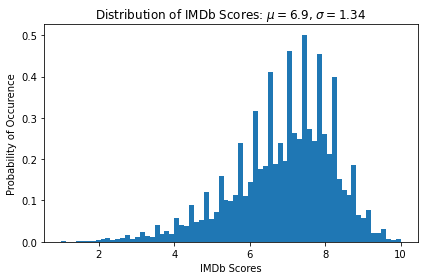

In [22]:
avg = np.mean(nflix['averageRating'])
sd = np.std(nflix['averageRating'])
title = 'Distribution of IMDb Scores: $\mu=$' + str(round(avg, 2)) + ', $\sigma=$' + str(round(sd, 2))

plt.hist(nflix['averageRating'], density = True, bins = 'auto')
plt.xlabel('IMDb Scores')
plt.ylabel('Probability of Occurence')
plt.title(title)

plt.tight_layout()
#plt.savefig('/out/imdb_histogram.png', dpi=600)
plt.show()

********

## Reshaping/Preprocessing

We want to change the structure of the data to substantially reduce the complexity of the input features. Let's first separate things into structures that make sense. This is mainly a text processing problem.

Split 'title' and 'description' by every space:

In [23]:
# make a copy
nflix_sub = nflix.copy()
nflix_sub['title'] = nflix_sub['title'].str.split(' ')
nflix_sub['title']

0                                                 [['3%']]
1                                                 [['3%']]
2                                               [['7:19']]
3                                              [['23:59']]
4                                                  [['9']]
                               ...                        
22408                                         [['Zubaan']]
22409                                         [['Zubaan']]
22410                  [['Zulu',, 'Man',, 'in',, 'Japan']]
22411                  [["Zumbo's",, 'Just',, 'Desserts']]
22412    [['ZZ',, 'TOP:',, 'THAT',, 'LITTLE',, "OL'",, ...
Name: title, Length: 22413, dtype: object

We also want to remove unnecessary conjoining (i.e. 'stop') words and punctuation from the description in order to reduce its size and maximize its feature importance:

In [24]:
stop = text.ENGLISH_STOP_WORDS

# coerce to lowercase to match stop words
nflix_sub['description'] = nflix_sub['description'].str.lower()
nflix_sub['description'] = nflix_sub['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
nflix_sub['description'] = nflix_sub['description'].apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
nflix_sub['description']

0         
1         
2         
3         
4         
        ..
22408     
22409     
22410     
22411     
22412     
Name: description, Length: 22413, dtype: object

In [25]:
nflix_sub['description'] = nflix_sub['description'].str.split(' ')
nflix_sub['description']

0        []
1        []
2        []
3        []
4        []
         ..
22408    []
22409    []
22410    []
22411    []
22412    []
Name: description, Length: 22413, dtype: object

Split cast on commas:

In [26]:
nflix_sub['cast'] = nflix_sub['cast'].str.split(',')
nflix_sub['cast']

0        [['João Miguel',  ' Bianca Comparato',  ' Mich...
1        [['João Miguel',  ' Bianca Comparato',  ' Mich...
2        [['Demián Bichir',  ' Héctor Bonilla',  ' Osca...
3        [['Tedd Chan',  ' Stella Chung',  ' Henley Hii...
4        [['Elijah Wood',  ' John C. Reilly',  ' Jennif...
                               ...                        
22408    [['Vicky Kaushal',  ' Sarah-Jane Dias',  ' Raa...
22409    [['Vicky Kaushal',  ' Sarah-Jane Dias',  ' Raa...
22410                                        [['Nasty C']]
22411                 [['Adriano Zumbo',  ' Rachel Khoo']]
22412                                                  NaN
Name: cast, Length: 22413, dtype: object

Now, entries which were large text strings are now represented as lists of much smaller strings.

In [28]:
nflix_sub = nflix_sub[['title', 'director', 'cast', 'country', 'date_added', 'rating',
           'release_year', 'duration', 'description','averageRating', 'numVotes']]
#nflix_sub.to_csv('../data/nflix_sub.csv')

### Frequency of unique terms

In [29]:
def count_unique(col):
    col = col.dropna()
    return len(set(itertools.chain.from_iterable(col)))

list_features = ['title', 'cast', 'description']

for f in list_features:
    print(f, ": ", str(count_unique(nflix_sub[f])))

title :  11708
cast :  37710
description :  1


In [30]:
# above method doesn't work on single entries
single_features = ['director', 'duration', 'country', 'rating']

for f in single_features:
    print(f, ":", len(set(nflix_sub[f].dropna())))

director : 4049
duration : 216
country : 681
rating : 14


*******

## Feature Engineering and Algorithms

Update: taking a different approach to feature extraction.

### Detect missingness

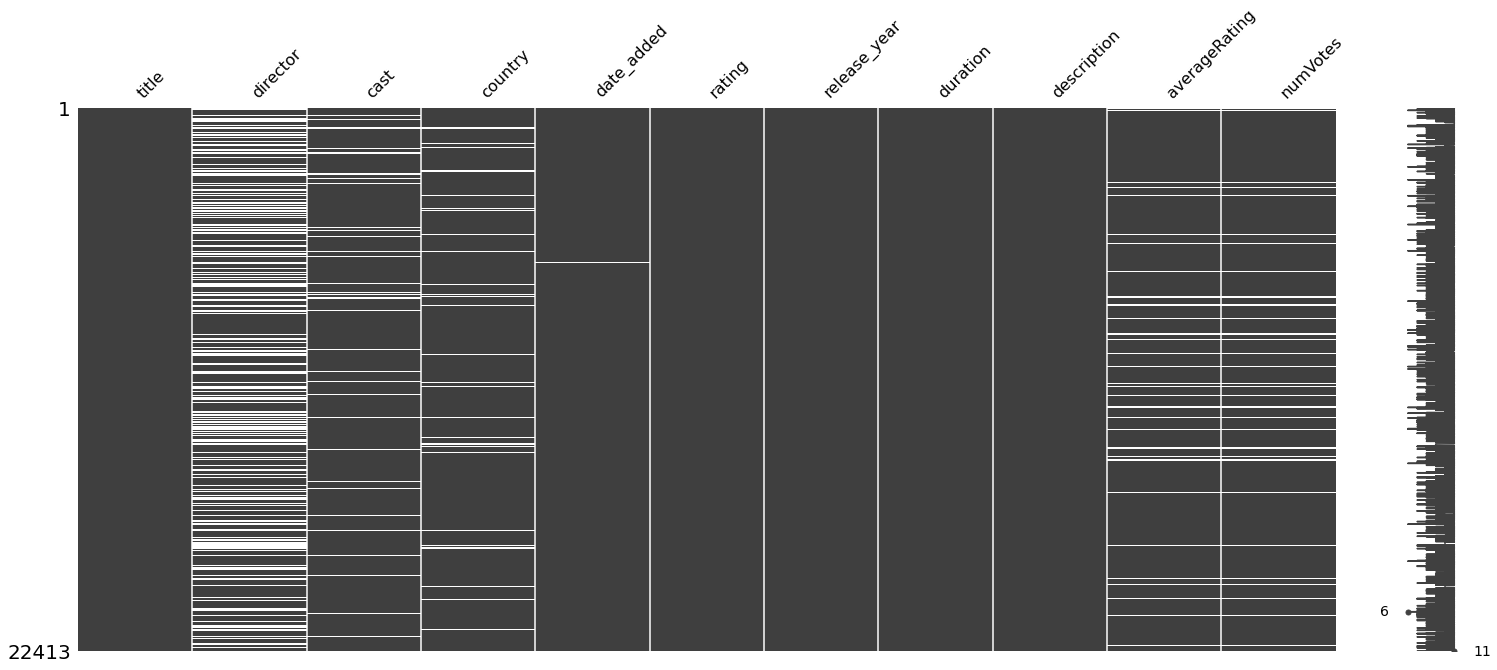

In [31]:
# create susbset of useful columns
nflix_sub = nflix[['title', 'director', 'cast', 'country', 'date_added', 'rating',
           'release_year', 'duration', 'description','averageRating', 'numVotes']]

# drop entries without response variable
nflix = nflix[nflix['averageRating'].isna() == False]

# nifty little missing data visualizer: https://github.com/ResidentMario/missingno.git
msno.matrix(nflix_sub)
#plt.savefig('../out/merged_missing.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
nflix_sub = nflix_sub[nflix_sub['averageRating'].isna() == False] 

y = nflix_sub['averageRating'].values.ravel()

X = nflix_sub.drop(columns=['averageRating', 'director'])

#X = nflix.drop(columns = ['date_added', 'director'])

#X.info() #sanity check

print('Here!', nflix['averageRating'].isna().sum())

#for column in X:
#    X[column] = le.fit_transform(X[column])


#covMatrix = pd.DataFrame.cov(X)
#print(covMatrix)
#sn.heatmap(covMatrix, annot=True, fmt='g')
#plt.show()

Here! 0


In [41]:

def sepdata(nonan_imp):
    '''separates numerical and categorical variables into subsets
    quant and qual'''    
    for name in nonan_imp.columns:
        if type(nonan_imp[name][1]) == str:
            nonan_imp[name] = nonan_imp[name].astype(str)
        elif type(nonan_imp[name][1]) == int:
            #print(name)
            nonan_imp[name] = nonan_imp[name].astype(int)
        else:
            #nonan_imp[name] = pd.to_numeric(nonan_imp[name])
            nonan_imp[name] = nonan_imp[name].astype(str)

    quant = nonan_imp.select_dtypes(['number', 'float', 'int'])
    #print(quant.head)
    qual = nonan_imp.select_dtypes(['object'])
    #print(qual.head)
    return quant, qual

def prep():
    ''' produces a clean dataframe of X predictors and the y response 
    also encodes categorical variables'''
    fulldf = X
    ''' cut needs to be value between 0 and 1'''
    #nonan = dropcolna(fulldf, cut*len(fulldf))
    #nonan_imp = impute(nonan, 'most_frequent') #can use median here    
    quant, qual = sepdata(X)    
    #nona_enc = nonan_imp
    X_enc = X

    '''
    encoding catergorical variables
    '''    
    le = LabelEncoder()
    X_enc[qual.columns] = X_enc[qual.columns].apply(lambda
                col:le.fit_transform(col))    
#    print(nona_enc.head)    

    #y = y.values.ravel()
    
    return X


#quant, qual = sepdata(X)
#X = prep()
#y = y.values.ravel()



def dropcolna(nonan):
    ''' takes full dataframe and drops columns with more missingness
    than the number, num, established by the cutoff later'''
    
    for feat in nonan.columns:
        if nonan[feat].isna().sum() > len(nonan):
            nonan.drop([feat], axis=1, inplace=True)
        else:
            '''sanity check for remaining nan'''
            print(feat, nonan[feat].isna().sum())
            pass
    print('new shape:', nonan.shape)
    return nonan

def impute(nonan):
    ''' imputes missing data by specified strategy, used 
    most frequent in this project'''
    values = nonan.values

    imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')    
    transformed_X = imp.fit_transform(X)    
    nonan_imp = pd.DataFrame(transformed_X, 
                             columns = [item for item in nonan.columns])
#    nonan_imp['days_to_death'] = y
    ''' sanity check to make sure there is no missingness left'''    
    print(nonan_imp)    
    for feat in nonan_imp:
        print('Here!', feat, nonan_imp[feat].isna().sum())
    return nonan_imp 



X = dropcolna(X)
#X_imp = impute(X)

title 0
cast 1420
country 945
date_added 54
rating 5
release_year 0
duration 0
description 0
numVotes 0
new shape: (20304, 9)


In [42]:
X

,title,cast,country,date_added,rating,release_year,duration,description,numVotes
0,['3%'],"['João Miguel', ' Bianca Comparato', ' Michel ...",Brazil,"August 14, 2020",TV-MA,2020,4 Seasons,"['future', 'elite', 'inhabit', 'island', 'para...",2053.0
1,['3%'],"['João Miguel', ' Bianca Comparato', ' Michel ...",Brazil,"August 14, 2020",TV-MA,2020,4 Seasons,"['future', 'elite', 'inhabit', 'island', 'para...",21771.0
2,['7:19'],"['Demián Bichir', ' Héctor Bonilla', ' Oscar S...",Mexico,"December 23, 2016",TV-MA,2016,93 min,"['devastating', 'earthquake', 'hits', 'mexico'...",567.0
3,['23:59'],"['Tedd Chan', ' Stella Chung', ' Henley Hii', ...",Singapore,"December 20, 2018",R,2011,78 min,"['army', 'recruit', 'fellow', 'soldiers', 'for...",849.0
4,['9'],"['Elijah Wood', ' John C. Reilly', ' Jennifer ...",United States,"November 16, 2017",PG-13,2009,80 min,"['postapocalyptic', 'robots', 'hide', 'fear', ...",73.0
...,...,...,...,...,...,...,...,...,...
22406,['Zozo'],"['Imad Creidi', ' Antoinette Turk', ' Elias Ge...","Sweden, Czech Republic, United Kingdom, Denmar...","October 19, 2020",TV-MA,2005,99 min,"['civil', 'war', 'deprives', 'zozo', 'left', '...",3075.0
22407,['Zozo'],"['Imad Creidi', ' Antoinette Turk', ' Elias Ge...","Sweden, Czech Republic, United Kingdom, Denmar...","October 19, 2020",TV-MA,2005,99 min,"['civil', 'war', 'deprives', 'zozo', 'left', '...",32.0
22408,['Zubaan'],"['Vicky Kaushal', ' Sarah-Jane Dias', ' Raagha...",India,"March 2, 2019",TV-14,2015,111 min,"['scrappy', 'poor', 'boy', 'worms', 'way', 'dy...",389.0
22409,['Zubaan'],"['Vicky Kaushal', ' Sarah-Jane Dias', ' Raagha...",India,"March 2, 2019",TV-14,2015,111 min,"['scrappy', 'poor', 'boy', 'worms', 'way', 'dy...",10.0


The amount of missingness in the `director` column might make it a poor candidate to use in prediction.

### Encoding Data

In [56]:
# split into train and testing sets
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

# vectorize training and testing features (separately)

def vectorize_data(X_train, X_test):
    '''Takes corpus of feature words and returns sparse tf-idf-vectorized matrix.
    Handles test and training data with different methods.'''
    
    # replace missing values with empty string
    X_train = X_train.fillna("")
    X_test = X_test.fillna("")
    
    vectorizer = text.TfidfVectorizer(analyzer='word', stop_words='english')
    
    train_out = vectorizer.fit_transform(X_train)
    test_out = vectorizer.fit_transform(X_test)
    
    return list(train_out), list(test_out)

X_train['description'], X_test['description'] = vectorize_data(X_train['description'], X_test['description'])
X_train['cast'], X_test['cast'] = vectorize_data(X_train['cast'], X_test['cast'])
X_train['title'], X_test['title'] = vectorize_data(X_train['title'], X_test['title'])

<ipython-input-56-ad77ed0573e4>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['description'], X_test['description'] = vectorize_data(X_train['description'], X_test['description'])
<ipython-input-56-ad77ed0573e4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cast'], X_test['cast'] = vectorize_data(X_train['cast'], X_test['cast'])
<ipython-input-56-ad77ed0573e4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [57]:
X_train

,title,cast,country,date_added,rating,release_year,duration,description,numVotes
19773,"(0, 4277)\t1.0","(0, 17259)\t0.250068508042894\n (0, 21312)\...",NaN,"September 15, 2018",TV-14,2018,98 min,"(0, 4743)\t0.31942123811908\n (0, 5949)\t0....",6.0
8616,"(0, 2401)\t1.0","(0, 20227)\t0.36776729900676647\n (0, 19932...",Vietnam,"October 6, 2018",TV-14,2015,92 min,"(0, 7669)\t0.2423484385495067\n (0, 7815)\t...",106.0
2831,"(0, 700)\t1.0","(0, 21027)\t0.27074228579101933\n (0, 15266...",Brazil,"October 25, 2019",TV-MA,2019,1 Season,"(0, 2336)\t0.24124410665078436\n (0, 9004)\...",120.0
6145,"(0, 1736)\t1.0","(0, 13740)\t0.2847926029160692\n (0, 18868)...",India,"June 7, 2020",TV-14,2020,132 min,"(0, 12036)\t0.1266573773004539\n (0, 10627)...",2604.0
18081,"(0, 4067)\t0.612003237480157\n (0, 4917)\t0...","(0, 17279)\t0.22406843026161885\n (0, 8562)...",United Kingdom,"March 31, 2017",NR,2013,1 Season,"(0, 998)\t0.3632467693287683\n (0, 9040)\t0...",12.0
...,...,...,...,...,...,...,...,...,...
12673,"(0, 2513)\t0.7298891250848777\n (0, 3645)\t...","(0, 10333)\t0.29953044012300034\n (0, 3822)...",United Kingdom,"December 22, 2018",TV-MA,2018,5 Seasons,"(0, 10039)\t0.3569301658810128\n (0, 7004)\...",138.0
13423,"(0, 4602)\t0.7345705410486073\n (0, 3931)\t...","(0, 6981)\t0.3012768843445443\n (0, 7447)\t...","United States, India","September 24, 2020",PG-13,2011,127 min,"(0, 2188)\t0.3809786244598222\n (0, 9046)\t...",65.0
6010,"(0, 3063)\t1.0","(0, 5903)\t0.30164675094942606\n (0, 5887)\...",United States,"March 30, 2018",TV-MA,2018,103 min,"(0, 5662)\t0.3370508696174426\n (0, 4108)\t...",1973.0
1009,"(0, 229)\t1.0","(0, 7186)\t0.5614135457671998\n (0, 21371)\...",United Kingdom,"July 26, 2018",R,2015,128 min,"(0, 1656)\t0.2674466817202117\n (0, 5458)\t...",6.0


In [58]:
for feat in X:
    print('Here!', feat, X_imp[feat].isna().sum())

Here! title 0
Here! cast 0
Here! country 0
Here! date_added 0
Here! rating 0
Here! release_year 0
Here! duration 0
Here! description 0
Here! numVotes 0


In [64]:
#Lasso Regression

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV


def lasso(X_train, y_train):
            
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1],'fit_intercept':[True, False],'normalize':[True, False],
                  'tol': [1e-4, 1e-5, 1e-6],'warm_start': [True, False],'selection': ['cyclic', 'random']}
    
    best_mod = GridSearchCV(linear_model.Lasso(),
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',cv=5,
                            verbose=True, pre_dispatch='2*n_jobs', n_jobs=-1)

    #    param_grid = {'alpha': 0.001, 'fit_intercept': True, 'normalize': False,
    #                  'selection': 'random', 'tol': 0.0001, 'warm_start': True}
    #
    #    best_mod = linear_model.Lasso(alpha=0.001, fit_intercept=True, normalize=False,
    #                             selection = 'random', tol = 0.0001, warm_start=False)

    mod = best_mod.fit(X_train,y_train)    
    #print(best_mod.best_params_)    
    #mod = best_mod.best_estimator_

    
    imp = pd.Series(mod.coef_, index = X.columns)
    
    #imp = imp[(imp > 0.2) | (imp < -0.2)].sort_values()        

    print(imp)
    plt.rcParams.update({'font.size': 30, 'figure.figsize':(10, 20)})
    plt.gcf().subplots_adjust(left=0.3)
    
    plt.barh(X.columns, mod.coef_, color='red')
    plt.grid(color='gray', which='major', axis='y', linestyle='--', alpha=0.5)        
    plt.xlabel('Feature Importance')
    #plt.savefig('../out/logreg_featimp.png', dpi = 400)
    plt.show()    
    
    return mod, imp.index


In [67]:
#lasso(X_train, y_train)

In [66]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
#rng = np.random.RandomState(1)
#X = np.sort(5 * rng.rand(80, 1), axis=0)
#y = np.sin(X).ravel()
#y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

ValueError: setting an array element with a sequence.